In [5]:
import tensorflow as tf
import numpy as np
from tensorflow import keras

#Can be created using a finished SVDDense layer. Used to actually decrease the parameter count, and does not prune or compress anymore. 
class RecomposedDense(keras.layers.Layer):
    def __init__(self, units=32, weights = [], b = [], *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.units = units
        self.w = weights
        self.b = b

    def build(self, input_shape):

        self.w = self.add_weight(
            shape=(input_shape[-1], self.units), initializer=tf.constant_initializer(self.w), trainable=True, name="weights"
        )
        
        self.b = self.add_weight(
            shape=(self.units,), initializer=tf.constant_initializer(self.b), trainable=True, name="bias"
        )
        
    def call(self, inputs):

        #Temp test, try to immediately prune everything but 1
        # tf.cond(self.rank > 1, lambda: self.rank.assign_sub(1), lambda: self.rank)

        #Calculate loss for this layer
#        self.add_loss(0)
        x = tf.matmul(inputs, self.w)
        return x + self.b
    
class DecomposedDense(keras.layers.Layer):
    def __init__(self, units=32, u_sigma = [], vt = [], b = [], *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.units = units
        self.rank = 1 #Overwritten during build.
        self.u_sigma = u_sigma
        self.vt = vt
        self.b = b

    def build(self, input_shape):
        
        self.rank = int(tf.shape(self.u_sigma)[1])

        self.u_sigma = self.add_weight(
            shape=(input_shape[-1], self.rank), initializer=tf.constant_initializer(self.u_sigma), trainable=True, name="u"
        )

        if len(self.vt) == 1:
           self.vt = self.vt[0][0]

        self.vt = self.add_weight(
            shape=(self.rank, self.units), initializer=tf.constant_initializer(self.vt), trainable=True, name="vt"
            #shape=(int(self.rank), self.units), initializer='zeros', trainable=True, name="vt"
        )
        #self.vt.assign(vt)

        self.b = self.add_weight(
            shape=(self.units,), initializer=tf.constant_initializer(self.b), trainable=True, name="bias"
        )

        self.rank = tf.Variable(self.rank, trainable=False, dtype=tf.int32)

        
    def call(self, inputs):

        #Temp test, try to immediately prune everything but 1
        # tf.cond(self.rank > 1, lambda: self.rank.assign_sub(1), lambda: self.rank)

        #Calculate loss for this layer
#        self.add_loss(0)
        x = tf.matmul(inputs, self.u_sigma)
        x = tf.matmul(x, self.vt)
        return x + self.b

In [6]:
import numpy as np
import tensorflow as tf
import CustomModel
from tensorflow import keras


(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

x = x_train
y = y_train

y = keras.utils.to_categorical(y, num_classes=10)
y_test = keras.utils.to_categorical(y_test, num_classes=10)

# Construct an instance of CustomModel
inputs = keras.Input(shape=(np.shape(x)[-2], np.shape(x)[-1]))
flattened = keras.layers.Flatten()(inputs)
outputs = keras.layers.Dense(
    units = 600
)(flattened)
outputs = keras.layers.Activation('relu')(outputs)
outputs = keras.layers.Dense(
    units = 300
)(outputs)
outputs = keras.layers.Activation('relu')(outputs)
outputs = keras.layers.Dense(
    units = 10
)(outputs)
outputs = keras.layers.Activation('softmax')(outputs)
#outputs = keras.layers.Activation('sigmoid')(outputs)
model = CustomModel.CustomModel(inputs, outputs)

# We don't pass a loss or metrics here.
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-1, momentum=0.9, clipnorm=2.0))#learning_rate=5e-3, momentum=0.9, clipnorm=1.0))

# Just use `fit` as usual -- you can use callbacks, etc.
model.summary()
firstFit = model.fit(x, y, epochs=110, batch_size=1000, validation_data=(x_test, y_test))


Model: "custom_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_6 (Dense)             (None, 600)               471000    
                                                                 
 activation_6 (Activation)   (None, 600)               0         
                                                                 
 dense_7 (Dense)             (None, 300)               180300    
                                                                 
 activation_7 (Activation)   (None, 300)               0         
                                                                 
 dense_8 (Dense)             (None, 10)             

In [20]:
prune_threshold = 0.2

outputs = flattened
input_size = np.shape(x)[-1] * np.shape(x)[-2]
for layerIndex in range(2, len(model.layers)-2):
    layer = model.layers[layerIndex]
    if isinstance(layer, keras.layers.Dense):

        weights = layer.get_weights()
        
        rank = 0
        u, sigma, vt = np.linalg.svd(weights[0])
        for i in range(len(sigma)):
            if sigma[i] > prune_threshold * sigma[0]:
                rank += 1
            else:
                break
        
        
        
        if (input_size * layer.units) > (rank * (input_size + layer.units)):
            outputs = DecomposedDense(
                units = layer.units,
                u_sigma = np.matmul(u[:, :rank], np.diag(sigma[:rank])),
                vt = vt[:rank],
                b = weights[1]
            )(outputs)
            print('Decomposed layer', layerIndex, 'into rank', rank)
        else:
            print(input_size)
            print(layer.units)
            print(input_size * layer.units)
            print(rank * (input_size + layer.units))
            print('Left layer', layerIndex, ' untouched, it had rank:', rank)
            outputs = RecomposedDense(
                units = layer.units,
                weights = weights[0],
                b = weights[1]
            )(outputs)
        input_size = layer.units
    else:
        new_layer = layer.__class__.from_config(layer.get_config())
        outputs = new_layer(outputs)
layer = model.layers[len(model.layers)-2]
weights = layer.get_weights()
outputs = RecomposedDense(

    units = layer.units,
    weights = weights[0],
    b = weights[1]
    )(outputs)
outputs = keras.layers.Activation('softmax')(outputs)
#learning_rate=4e-2, momentum=0.9, clipnorm

newModel = CustomModel.CustomModel(inputs, outputs)
newModel.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=6e-3, momentum=0.4, clipnorm=1.0))#learning_rate=5e-3, momentum=0.9, clipnorm=1.0))
newModel.summary()
secondFit = newModel.fit(x, y, epochs=50, batch_size=2000, validation_data=(x_test, y_test))


Decomposed layer 2 into rank 82
Decomposed layer 4 into rank 25
Model: "custom_model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 decomposed_dense_21 (Decom  (None, 600)               114089    
 posedDense)                                                     
                                                                 
 activation_6 (Activation)   (None, 600)               0         
                                                                 
 decomposed_dense_22 (Decom  (None, 300)               22801     
 posedDense)                                                     
                                                     

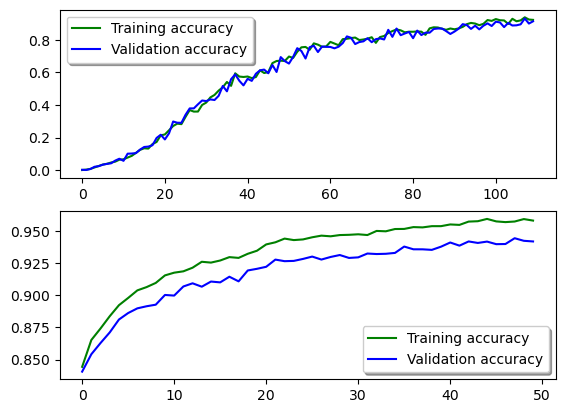

In [21]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2,1)

axes[0].plot(firstFit.history['acc'], color='g', label="Training accuracy")
axes[0].plot(firstFit.history['val_acc'], color='b', label="Validation accuracy")
axes[0].legend(loc='best', shadow=True)

axes[1].plot(secondFit.history['acc'], color='g', label="Training accuracy")
axes[1].plot(secondFit.history['val_acc'], color='b', label="Validation accuracy")
axes[1].legend(loc='best', shadow=True)

#ax[0].plot(firstFit.history['val_loss'], color='r', label="Validation Loss",axes =ax[0])
